Use this notebook to run 1 denoiser step and get updated intermediate steps

In [26]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=4, sci_mode=False)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers.umer_debug_logger import udl

In [4]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [5]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [6]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [7]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [8]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...


In [9]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

In [20]:
from types import SimpleNamespace

def tensor_file(i):   return f'logs/cloud/tensor_{i}.pt'
def tensor_file_l(i): return f'logs/local_cuda/tensor_{i}.pt'

inp = SimpleNamespace(
    context = SimpleNamespace(t=torch.load(tensor_file(26), map_location=device), expected_err=0.000),
    proj_in = SimpleNamespace(t=torch.load(tensor_file(44), map_location=device), expected_err=0.000),
    attn1   = SimpleNamespace(t=torch.load(tensor_file(45), map_location=device), expected_err=0.054),
    attn2   = SimpleNamespace(t=torch.load(tensor_file(49), map_location=device), expected_err=0.627),
    feedf   = SimpleNamespace(t=torch.load(tensor_file(51), map_location=device), expected_err=0.037),
)

inp_l = SimpleNamespace(
    context = SimpleNamespace(t=torch.load(tensor_file_l(26), map_location=device), expected_err=0.000),
    proj_in = SimpleNamespace(t=torch.load(tensor_file_l(44), map_location=device), expected_err=0.000),
    attn1   = SimpleNamespace(t=torch.load(tensor_file_l(45), map_location=device), expected_err=0.054),
    attn2   = SimpleNamespace(t=torch.load(tensor_file_l(49), map_location=device), expected_err=0.627),
    feedf   = SimpleNamespace(t=torch.load(tensor_file_l(51), map_location=device), expected_err=0.037),
)

Reminder: This is what a transformer block does:

In [ ]:
# h += attn1(norm1(h)) # 1. Self-Attention
# h += attn2(norm2(h)) # 2. Cross-Attention
# h += ff(norm3(h))    # 3. Feed-forward
# return h

In [15]:
attn_block = cnxs.control_model.down_blocks[1].attentions[0]
attn_block

Transformer2DModel(
  (norm): GroupNorm(32, 64, eps=1e-06, affine=True)
  (proj_in): LoRACompatibleConv(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (transformer_blocks): ModuleList(
    (0-1): 2 x BasicTransformerBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
        (to_k): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
        (to_v): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
        (to_out): ModuleList(
          (0): LoRACompatibleLinear(in_features=64, out_features=64, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
        (to_k): LoRACompatibleLinear(in_features=2048, out_features=64, bias=False)
      

In [16]:
norm1 = attn_block.transformer_blocks[0].norm1
attn1 = attn_block.transformer_blocks[0].attn1
norm2 = attn_block.transformer_blocks[0].norm2
attn2 = attn_block.transformer_blocks[0].attn2
norm3 = attn_block.transformer_blocks[0].norm3
feedf = attn_block.transformer_blocks[0].ff

In [17]:
h = inp.proj_in.t

x_norm1 = norm1(h)
x_attn1 = attn1(x_norm1)
h += x_attn1

x_norm2 = norm2(h)
x_attn2 = attn2(x_norm2, inp.context.t)
h += x_attn2

x_norm3 = norm3(h)
x_feedf = feedf(x_norm3)

In [23]:
def mae(t1,t2):
    if t1.shape!=t1.shape: raise ValueError("Shapes don't match")
    return (t1-t2).abs().mean().detach()

In [29]:
mae(x_attn1, inp_l.attn1.t), mae(x_attn2, inp_l.attn2.t), mae(x_feedf, inp_l.feedf.t)

(tensor(    0.0000, device='mps:0'),
 tensor(0.0014, device='mps:0'),
 tensor(    0.0000, device='mps:0'))

The outputs approx. match the local cuda logs.

In [27]:
mae(x_attn1, inp.attn1.t), mae(x_attn2, inp.attn2.t), mae(x_feedf, inp.feedf.t)

(tensor(0.0540, device='mps:0'),
 tensor(0.6262, device='mps:0'),
 tensor(0.0375, device='mps:0'))

However, there are large errors when comparing to cloud cuda:

**Interestingly, the errors are roughly the same as when we ignored adding attn1/attn2 back to the hidden states.**
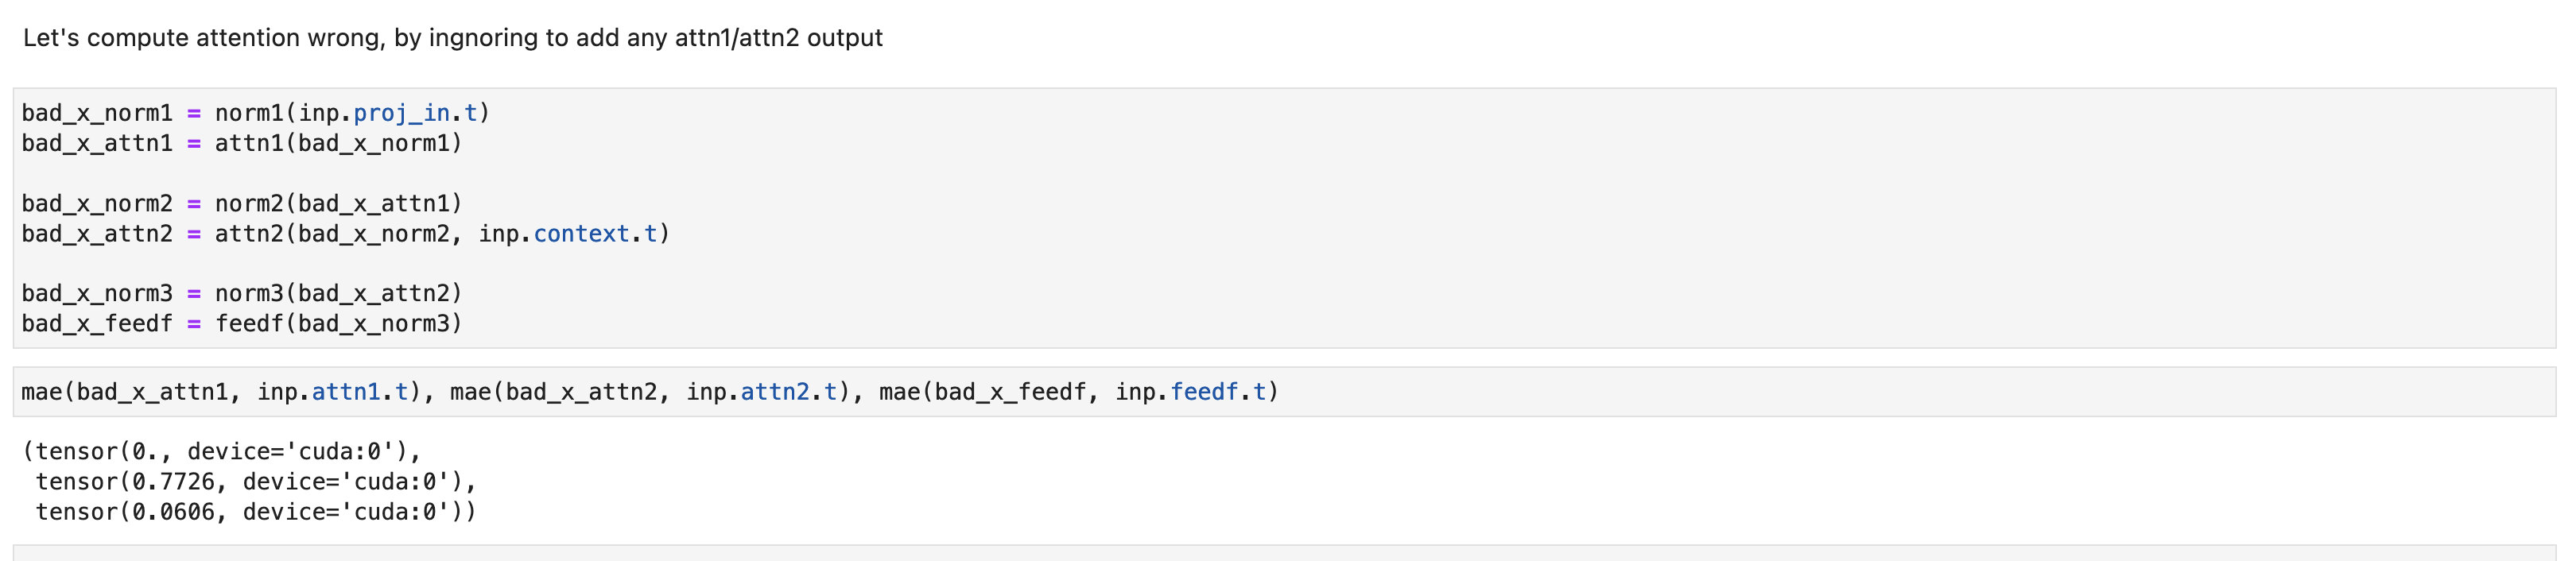
This could mean the output of attn1/attn2 is as bad as if it were non-existent

In [50]:
torch.set_printoptions(precision=3)
def print_head(m): print(m.weight.data.flatten()[:10])

In [49]:
print_head(attn1.to_q)
print_head(attn1.to_k)
print_head(attn1.to_v)
print_head(attn1.to_out[0])

print_head(attn2.to_q)
print_head(attn2.to_k)
print_head(attn2.to_v)
print_head(attn2.to_out[0])

print_head(feedf.net[2])

tensor([-0.071, -0.062, -0.003, -0.056,  0.030, -0.003, -0.015, -0.142, -0.017, -0.075], device='mps:0')
tensor([ 0.073,  0.008,  0.053, -0.025,  0.056,  0.094,  0.037, -0.085,  0.065, -0.010], device='mps:0')
tensor([-0.092,  0.013,  0.104, -0.014, -0.075, -0.126, -0.028, -0.007,  0.080,  0.094], device='mps:0')
tensor([-0.071, -0.053, -0.049, -0.112, -0.016, -0.115, -0.001,  0.109,  0.055,  0.020], device='mps:0')
tensor([ 0.091,  0.001, -0.058,  0.122, -0.091, -0.073,  0.009,  0.032,  0.011,  0.037], device='mps:0')
tensor([ 0.003, -0.020,  0.015,  0.005, -0.025, -0.025, -0.016,  0.003,  0.009,  0.024], device='mps:0')
tensor([ 0.021, -0.021, -0.020, -0.028, -0.007,  0.028,  0.028, -0.014,  0.003,  0.029], device='mps:0')
tensor([-0.042, -0.100, -0.041,  0.014,  0.087,  0.011, -0.054,  0.069,  0.096, -0.027], device='mps:0')
tensor([-0.015,  0.029, -0.066, -0.034, -0.022, -0.020, -0.085, -0.030, -0.075, -0.012], device='mps:0')


In [51]:
attn1

Attention(
  (to_q): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
  (to_k): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
  (to_v): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
  (to_out): ModuleList(
    (0): LoRACompatibleLinear(in_features=64, out_features=64, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)